<a href="https://colab.research.google.com/github/jarodriguezf/ASL_Alphabet/blob/main/HandModelV1_ASL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install mediapipe-model-maker

In [12]:
# Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io
from google.colab import files
import tensorflow as tf
assert tf.__version__.startswith('2')
import imageio
import random
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import cv2
from google.colab.patches import cv2_imshow
import math
import os
from mediapipe_model_maker import gesture_recognizer
import mediapipe as mp
%matplotlib inline
from sklearn.model_selection import train_test_split

In [3]:
# Montamos nuestro drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Cambiamos el directorio de trabajo, hasta la carpeta ASL_Alphabet (Raiz del proyecto)
%cd /content/drive/MyDrive/ASL_Alphabet/
%ls

/content/drive/MyDrive/ASL_Alphabet
asl_alphabet_test/   asl_alphabet_val/  df_val.csv
asl_alphabet_train/  df.csv             gesture_recognizer.task


In [5]:
dataset_path = "asl_alphabet_train/als_alphabet_train"

In [6]:
print(dataset_path)
labels = []
for i in os.listdir(dataset_path):
  if os.path.isdir(os.path.join(dataset_path, i)):
    labels.append(i)
print(labels)

asl_alphabet_train/als_alphabet_train
['D', 'del', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'none', 'B', 'C', 'A']


<ipython-input-7-63df9954d3e1>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, NUM_EXAMPLES, figsize=(10,2))


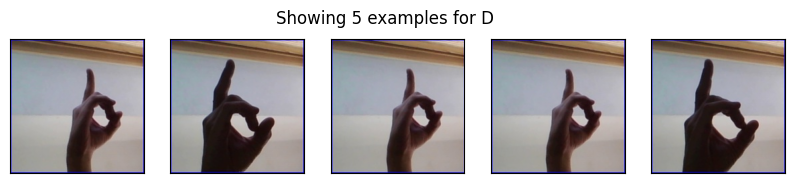

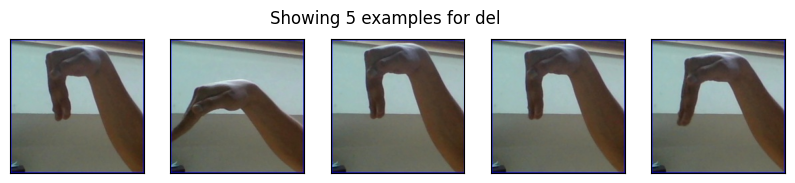

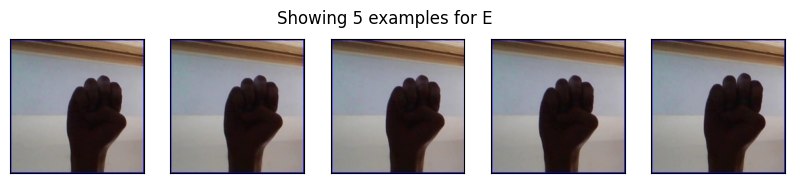

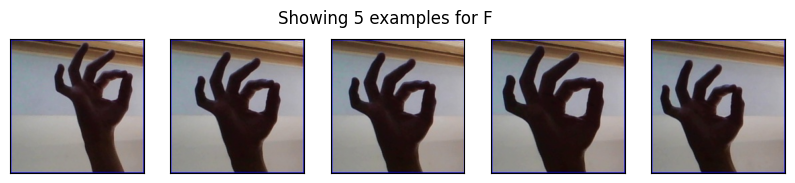

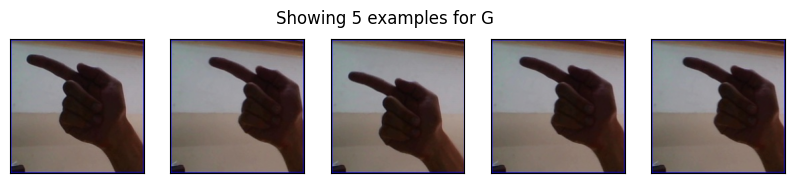

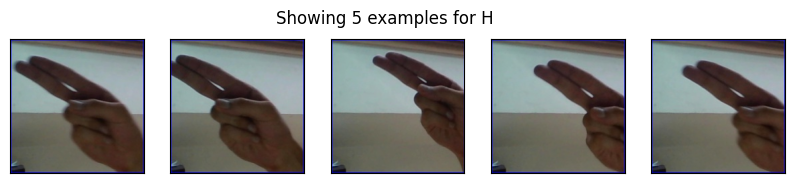

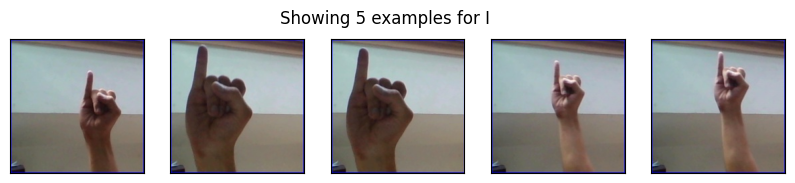

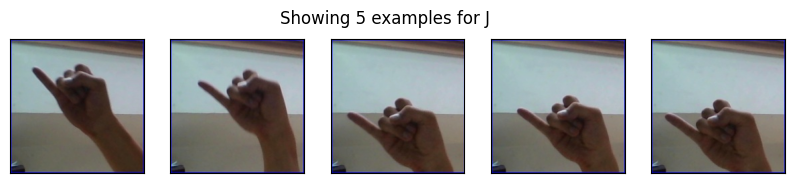

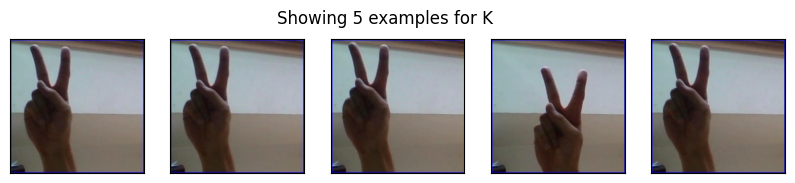

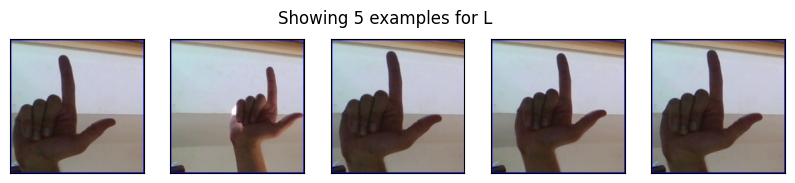

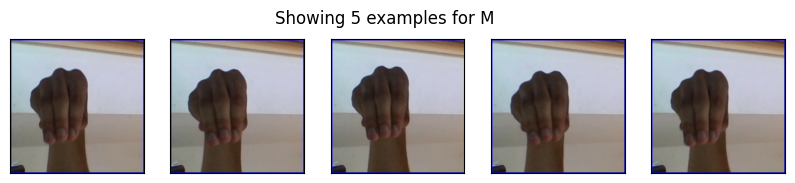

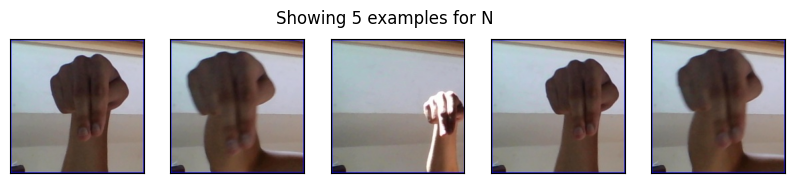

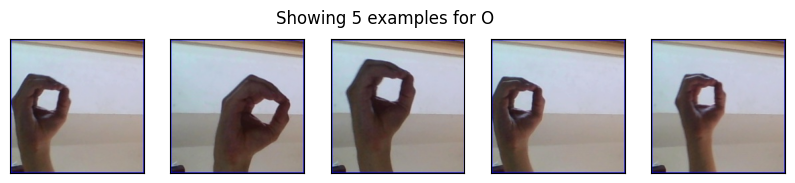

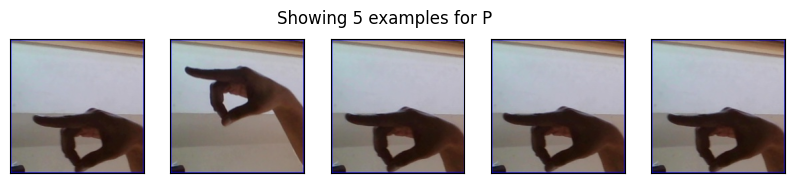

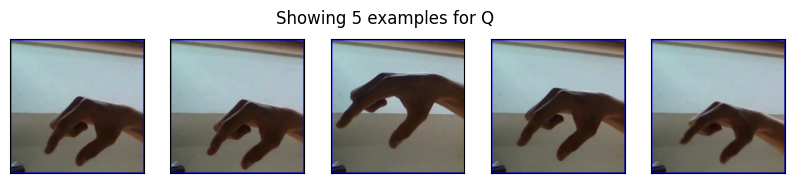

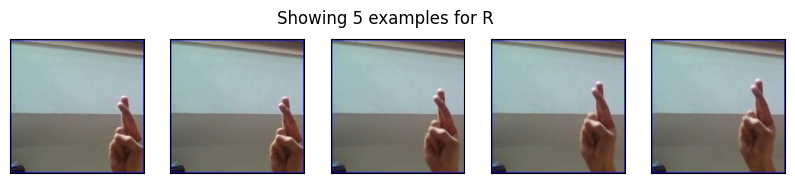

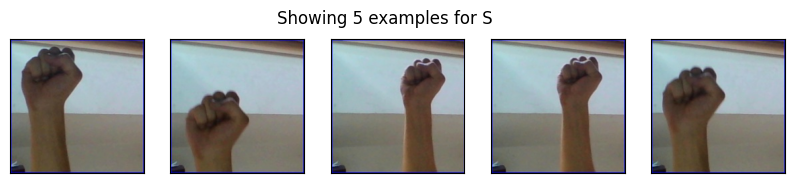

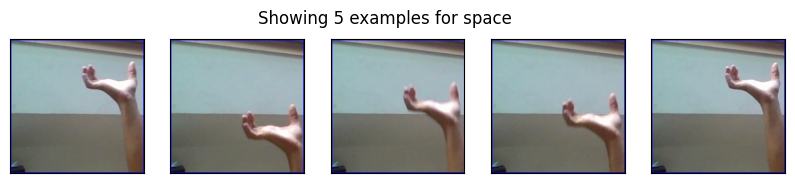

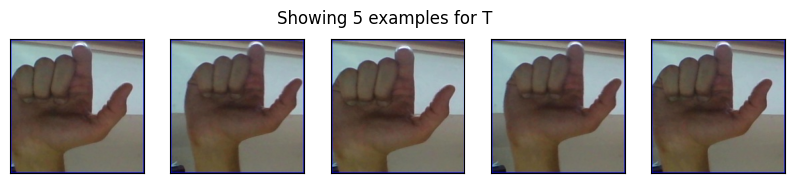

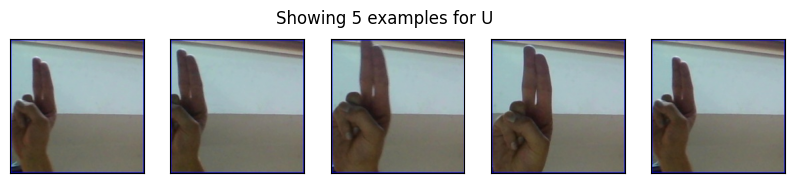

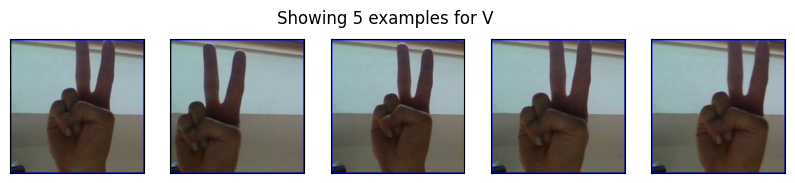

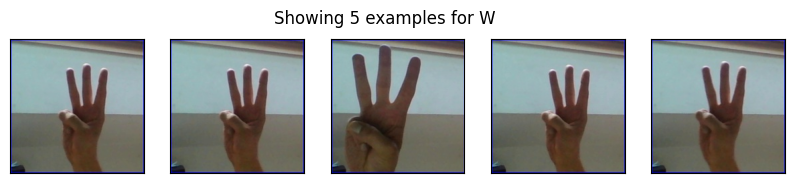

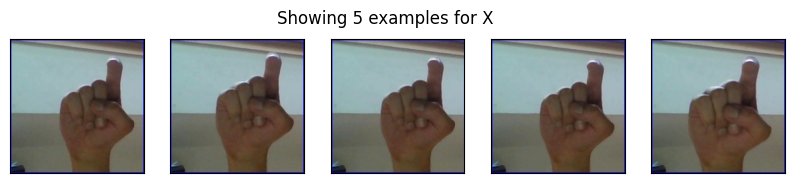

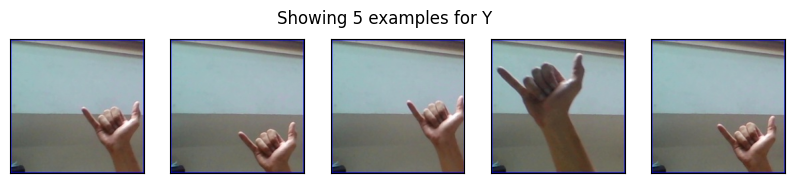

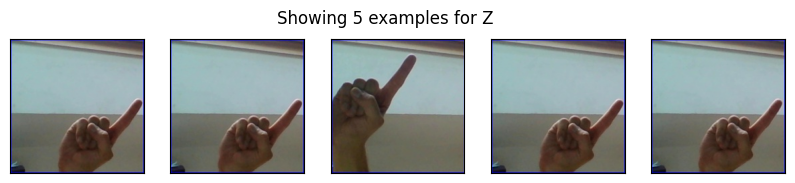

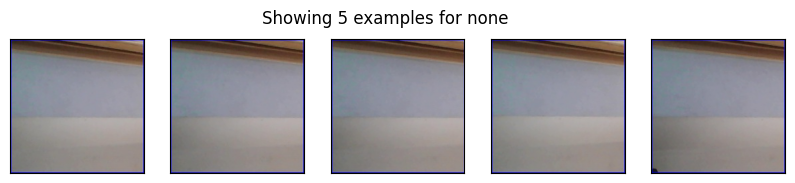

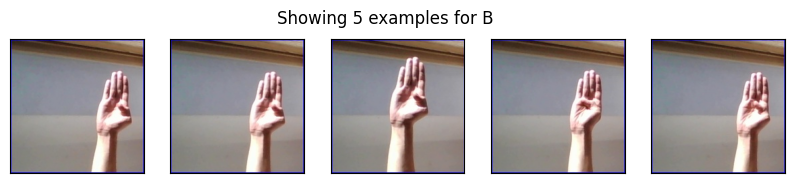

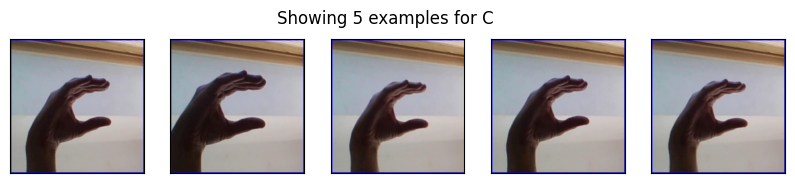

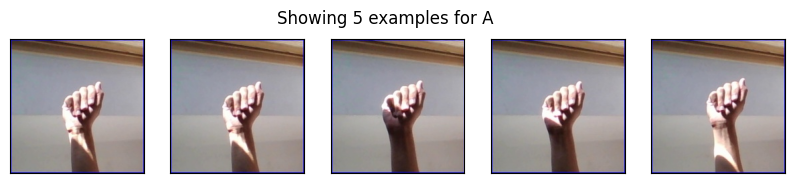

In [7]:
NUM_EXAMPLES = 5

for label in labels:
  label_dir = os.path.join(dataset_path, label)
  example_filenames = os.listdir(label_dir)[:NUM_EXAMPLES]
  fig, axs = plt.subplots(1, NUM_EXAMPLES, figsize=(10,2))
  for i in range(NUM_EXAMPLES):
    axs[i].imshow(plt.imread(os.path.join(label_dir, example_filenames[i])))
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
  fig.suptitle(f'Showing {NUM_EXAMPLES} examples for {label}')

plt.show()

In [8]:
data = gesture_recognizer.Dataset.from_folder(
    dirname=dataset_path,
    hparams=gesture_recognizer.HandDataPreprocessingParams()
)
train_data, rest_data = data.split(0.8)
validation_data, test_data = rest_data.split(0.5)

In [9]:
# Entrenamiento del modelo
hparams = gesture_recognizer.HParams(export_dir="exported_model")
options = gesture_recognizer.GestureRecognizerOptions(hparams=hparams)
model = gesture_recognizer.GestureRecognizer.create(
    train_data=train_data,
    validation_data=validation_data,
    options=options
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hand_embedding (InputLayer  [(None, 128)]             0         
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 custom_gesture_recognizer_  (None, 29)                3741      
 out (Dense)                                                     
                                                             

In [10]:
# Evaluar el rendimiento del modelo con conjunto de prueba
loss, acc = model.evaluate(test_data, batch_size=1)
print(f"Test loss:{loss}, Test accuracy:{acc}")

1067/1067 [==============================] - 32s 7ms/step - loss: 0.1404 - categorical_accuracy: 0.9203
Test loss:0.1404450386762619, Test accuracy:0.9203373789787292


In [11]:
# Guardar modelo
model.export_model()
!ls exported_model

Using existing files at /tmp/model_maker/gesture_recognizer/palm_detection_full.tflite
Using existing files at /tmp/model_maker/gesture_recognizer/hand_landmark_full.tflite
best_model_weights.data-00000-of-00001	checkpoint    gesture_recognizer.task  metadata.json
best_model_weights.index		epoch_models  logs


PROBAMOS CON OTRO CONJUNTO DE PRUEBA VISUALIZANDOLO

In [13]:
# Cargamos las imagenes de test
X_Test=[]
labels=['A_test','B_test','C_test','D_test','E_test','F_test','G_test','H_test','I_test','J_test','K_test','L_test',
        'M_test','N_test','nothing_test','O_test','P_test','Q_test','R_test','S_test','space_test','T_test','U_test',
        'V_test','W_test','X_test','Y_test','Z_test']
for i in range(28):
  X_Test.append(f'asl_alphabet_test/asl_alphabet_test/{labels[i]}.jpg')

In [14]:
model_path = 'exported_model/gesture_recognizer.task'

In [15]:
from matplotlib import pyplot as plt
import mediapipe as mp
from mediapipe.framework.formats import landmark_pb2

plt.rcParams.update({
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.spines.left': False,
    'axes.spines.bottom': False,
    'xtick.labelbottom': False,
    'xtick.bottom': False,
    'ytick.labelleft': False,
    'ytick.left': False,
    'xtick.labeltop': False,
    'xtick.top': False,
    'ytick.labelright': False,
    'ytick.right': False
})

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles


def display_one_image(image, title, subplot, titlesize=16):
    """Displays one image along with the predicted category name and score."""
    plt.subplot(*subplot)
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize), color='black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)


def display_batch_of_images_with_gestures_and_hand_landmarks(images, results):
    """Displays a batch of images with the gesture category and its score along with the hand landmarks."""
    # Images and labels.
    images = [image.numpy_view() for image in images]
    gestures = [top_gesture for (top_gesture, _) in results]
    multi_hand_landmarks_list = [multi_hand_landmarks for (_, multi_hand_landmarks) in results]

    # Auto-squaring: this will drop data that does not fit into square or square-ish rectangle.
    rows = int(math.sqrt(len(images)))
    cols = len(images) // rows

    # Size and spacing.
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols, 1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))

    # Display gestures and hand landmarks.
    for i, (image, gestures) in enumerate(zip(images[:rows*cols], gestures[:rows*cols])):
        title = f"{gestures.category_name} ({gestures.score:.2f})"
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols) * 40 + 3
        annotated_image = image.copy()

        for hand_landmarks in multi_hand_landmarks_list[i]:
          hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
          hand_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
          ])

          mp_drawing.draw_landmarks(
            annotated_image,
            hand_landmarks_proto,
            mp_hands.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style())

        subplot = display_one_image(annotated_image, title, subplot, titlesize=dynamic_titlesize)

    # Layout.
    plt.tight_layout()
    plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

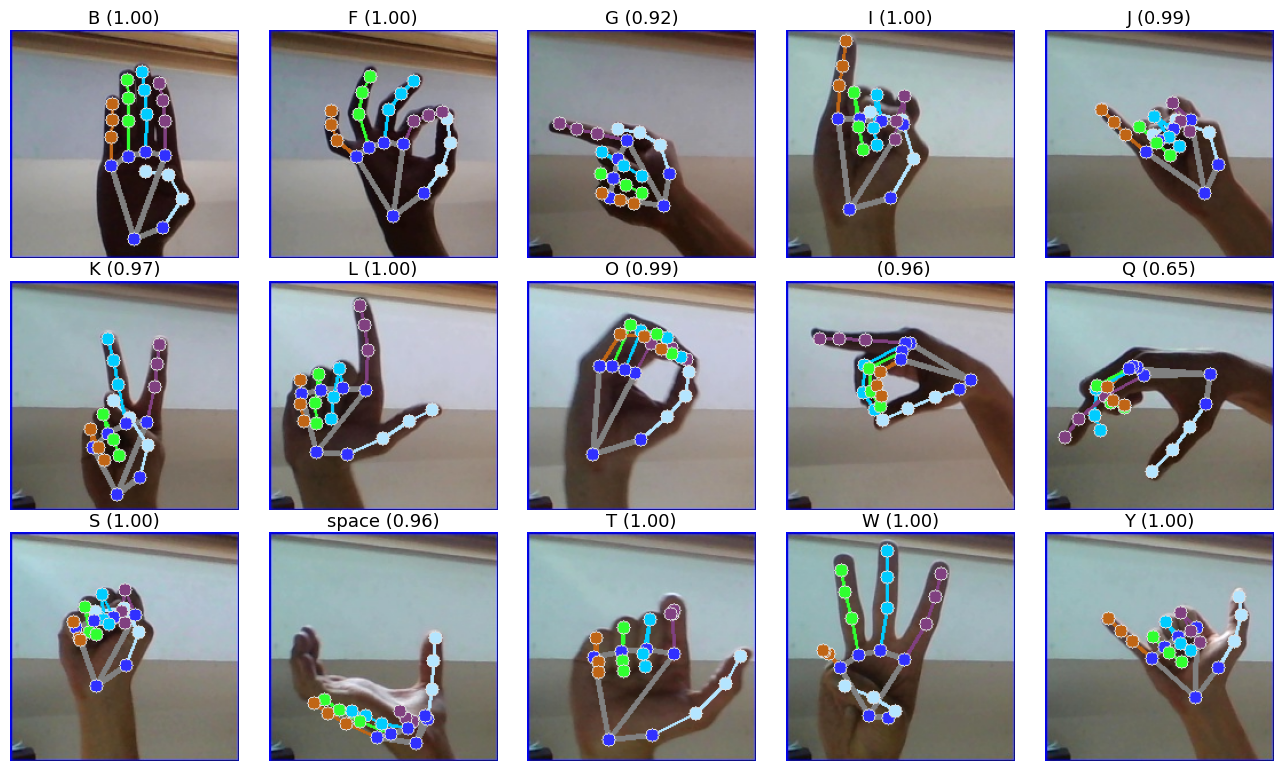

In [18]:
base_options = python.BaseOptions(model_asset_path=model_path)
options = vision.GestureRecognizerOptions(base_options=base_options)
recognizer = vision.GestureRecognizer.create_from_options(options)

images = []
results = []
results_unrecognized = []

for image_file_name in X_Test:
    # STEP 3: Load the input image.
  image = mp.Image.create_from_file(image_file_name)
    # STEP 4: Recognize gestures in the input image.
  recognition_result = recognizer.recognize(image)

  #print(recognition_result)
  # STEP 5: Process the result. In this case, visualize it.

  if recognition_result.gestures:
    images.append(image)
    top_gesture = recognition_result.gestures[0][0]
    hand_landmarks = recognition_result.hand_landmarks
    results.append((top_gesture, hand_landmarks))

  else:
    # Manejar el caso en que no se hayan reconocido gestos
    results_unrecognized.append(("No gesture recognized", None))

display_batch_of_images_with_gestures_and_hand_landmarks(images, results)


In [19]:
results_unrecognized

[('No gesture recognized', None),
 ('No gesture recognized', None),
 ('No gesture recognized', None),
 ('No gesture recognized', None),
 ('No gesture recognized', None),
 ('No gesture recognized', None),
 ('No gesture recognized', None),
 ('No gesture recognized', None),
 ('No gesture recognized', None),
 ('No gesture recognized', None),
 ('No gesture recognized', None),
 ('No gesture recognized', None),
 ('No gesture recognized', None)]